<a href="https://colab.research.google.com/github/Moinuddin-Hasan/credit-card-fraud-detection/blob/main/credit_card_fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Credit Card Fraud Detection - Data Preprocessing Pipeline Summary

## Dataset Overview
- **Training**: 1.3M samples, 23 features, 0.58% fraud rate
- **Test**: 556K samples, same structure, 0.39% fraud rate
- **Source**: Credit Card Transactions Fraud Detection Dataset (2019-2020)

## Preprocessing Steps

### 1. Data Loading & Quality Check
- Loaded train/test CSV files (1GB+ total)
- Verified no missing values or duplicates
- Identified severe class imbalance typical of fraud detection

### 2. Feature Engineering
- **Temporal**: Extracted hour, day, month, day-of-week from transaction timestamps
- **Demographics**: Calculated customer age from date of birth
- **Cleanup**: Removed identifiers (cc_num, trans_num) and PII (names, addresses)
- **Redundancy**: Dropped correlated geographic features (kept state/zip, removed lat/long)

### 3. Encoding & Scaling Pipeline
- **High-cardinality categoricals** (merchant, city): TargetEncoder with CV=5
- **Low-cardinality categoricals** (category, gender, state): OneHotEncoder
- **Numeric features**: MinMaxScaler (0-1 range)
- **Result**: 18 input features → 74 encoded features (sparse format, 84% zeros)

### 4. Class Balancing
- Applied SMOTE only on training data (no test contamination)
- Balanced from 0.58% to 50% fraud rate for training
- Training samples: 1.3M → 2.6M (doubled due to synthetic samples)

### 5. Data Export
- **Primary files**: X_train_balanced_final.npz (SMOTE), y_train_balanced_final.npy
- **Test files**: X_test_processed_final.npz, y_test_final.npy (original distribution)
- **Pipeline**: preprocessing_pipeline.pkl for consistent future transforms
- **Format**: Sparse matrices for memory efficiency (180MB vs GB for dense)

## Key Results
- Memory-efficient sparse format with proper train/test separation
- Leakage-safe preprocessing (pipeline fitted only on training data)
- Balanced training data for model learning, realistic test for evaluation
- Transaction amount identified as strongest fraud predictor (r=0.22)
- Ready for ensemble training with LightGBM + CatBoost + uncertainty quantification

## Files for Model Training
**Load balanced training data**
- X_train = sp.load_npz('X_train_balanced_final.npz')
- y_train = np.load('y_train_balanced_final.npy')

**Load test data (original distribution)**
- X_test = sp.load_npz('X_test_processed_final.npz')
- y_test = np.load('y_test_final.npy')

In [1]:
!pip install imbalanced-learn
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder, TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from scipy import stats
import scipy.sparse as sp
import seaborn as sns, matplotlib as mpl, matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import warnings
from datetime import datetime

print("Loading Credit Card Fraud Detection Dataset...")
train_data = pd.read_csv('fraudTrain.csv')
test_data = pd.read_csv('fraudTest.csv')

print("Training data loaded: {train_data.shape}")
print("Test data loaded: {test_data.shape}")


sns.set_theme(style="ticks", palette="deep")            # consistent base style [12]
sns.set_context("paper", font_scale=1.2)                # tuned for publication [15]
mpl.rcParams.update({
    "figure.dpi": 300, "savefig.dpi": 300,              # high-resolution figures
    "axes.spines.top": False, "axes.spines.right": False,
    "axes.grid": True, "grid.alpha": 0.2,               # subtle grid for readability
    "legend.frameon": False
})

def finalize_axes(ax, xlabel=None, ylabel=None, title=None):
    if xlabel: ax.set_xlabel(xlabel)
    if ylabel: ax.set_ylabel(ylabel)
    if title:  ax.set_title(title, pad=10, weight="bold")
    sns.despine(ax=ax)
    return ax

def savefig(path):
    plt.tight_layout()
    plt.savefig(path, bbox_inches="tight", facecolor="white")


Loading Credit Card Fraud Detection Dataset...
Training data loaded: {train_data.shape}
Test data loaded: {test_data.shape}


In [2]:
print("\n" + "="*50)
print("PHASE 2: INITIAL DATA INSPECTION")
print("="*50)

# Basic dataset information
print("\n📋 TRAIN DATASET INFO:")
print(f"Shape: {train_data.shape}")
print(f"Memory usage: {train_data.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\nDATA TYPES:")
print(train_data.dtypes.value_counts())

print("\nFIRST 5 ROWS:")
print(train_data.head())

print("\nDESCRIPTIVE STATISTICS:")
print(train_data.describe(include='all'))


PHASE 2: INITIAL DATA INSPECTION

📋 TRAIN DATASET INFO:
Shape: (1296675, 23)
Memory usage: 1034.99 MB

DATA TYPES:
object     12
int64       6
float64     5
Name: count, dtype: int64

FIRST 5 ROWS:
   Unnamed: 0 trans_date_trans_time            cc_num  \
0           0   2019-01-01 00:00:18  2703186189652095   
1           1   2019-01-01 00:00:44      630423337322   
2           2   2019-01-01 00:00:51    38859492057661   
3           3   2019-01-01 00:01:16  3534093764340240   
4           4   2019-01-01 00:03:06   375534208663984   

                             merchant       category     amt      first  \
0          fraud_Rippin, Kub and Mann       misc_net    4.97   Jennifer   
1     fraud_Heller, Gutmann and Zieme    grocery_pos  107.23  Stephanie   
2                fraud_Lind-Buckridge  entertainment  220.11     Edward   
3  fraud_Kutch, Hermiston and Farrell  gas_transport   45.00     Jeremy   
4                 fraud_Keeling-Crist       misc_pos   41.96      Tyler   

      l

In [3]:
print("\n" + "="*50)
print("PHASE 3: DATA CLEANING")
print("="*50)

def clean_dataset(df, dataset_name="Dataset"):
    print(f"\nCLEANING {dataset_name.upper()}...")

    missing_values = df.isnull().sum()
    print(f"\nMISSING VALUES:")
    print(missing_values[missing_values > 0])

    if missing_values.sum() == 0:
        print("No missing values found!")
    else:
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

        if 'is_fraud' in numeric_cols:
            numeric_cols.remove('is_fraud')

        if len(numeric_cols) > 0:
            num_imputer = SimpleImputer(strategy='median')
            df[numeric_cols] = num_imputer.fit_transform(df[numeric_cols])

        if len(categorical_cols) > 0:
            cat_imputer = SimpleImputer(strategy='most_frequent')
            df[categorical_cols] = cat_imputer.fit_transform(df[categorical_cols])

    duplicates = df.duplicated().sum()
    print(f"\nDUPLICATES: {duplicates}")
    if duplicates > 0:
        df.drop_duplicates(inplace=True)
        print(f"Removed {duplicates} duplicates")

    if 'amt' in df.columns:
        Q1 = df['amt'].quantile(0.25)
        Q3 = df['amt'].quantile(0.75)
        IQR = Q3 - Q1
        outlier_threshold = Q3 + 1.5 * IQR
        outliers = (df['amt'] > outlier_threshold).sum()
        print(f"\nTRANSACTION AMOUNT OUTLIERS (>Q3+1.5*IQR): {outliers}")

    return df

train_data_clean = clean_dataset(train_data.copy(), "TRAIN")
test_data_clean = clean_dataset(test_data.copy(), "TEST")



PHASE 3: DATA CLEANING

CLEANING TRAIN...

MISSING VALUES:
Series([], dtype: int64)
No missing values found!

DUPLICATES: 0

TRANSACTION AMOUNT OUTLIERS (>Q3+1.5*IQR): 67290

CLEANING TEST...

MISSING VALUES:
Series([], dtype: int64)
No missing values found!

DUPLICATES: 0

TRANSACTION AMOUNT OUTLIERS (>Q3+1.5*IQR): 27778



PHASE 4: INITIAL EXPLORATORY DATA ANALYSIS

CLASS DISTRIBUTION (TRAIN):
is_fraud
0    1289169
1       7506
Name: count, dtype: int64
Fraud rate: 0.0058 (0.58%)


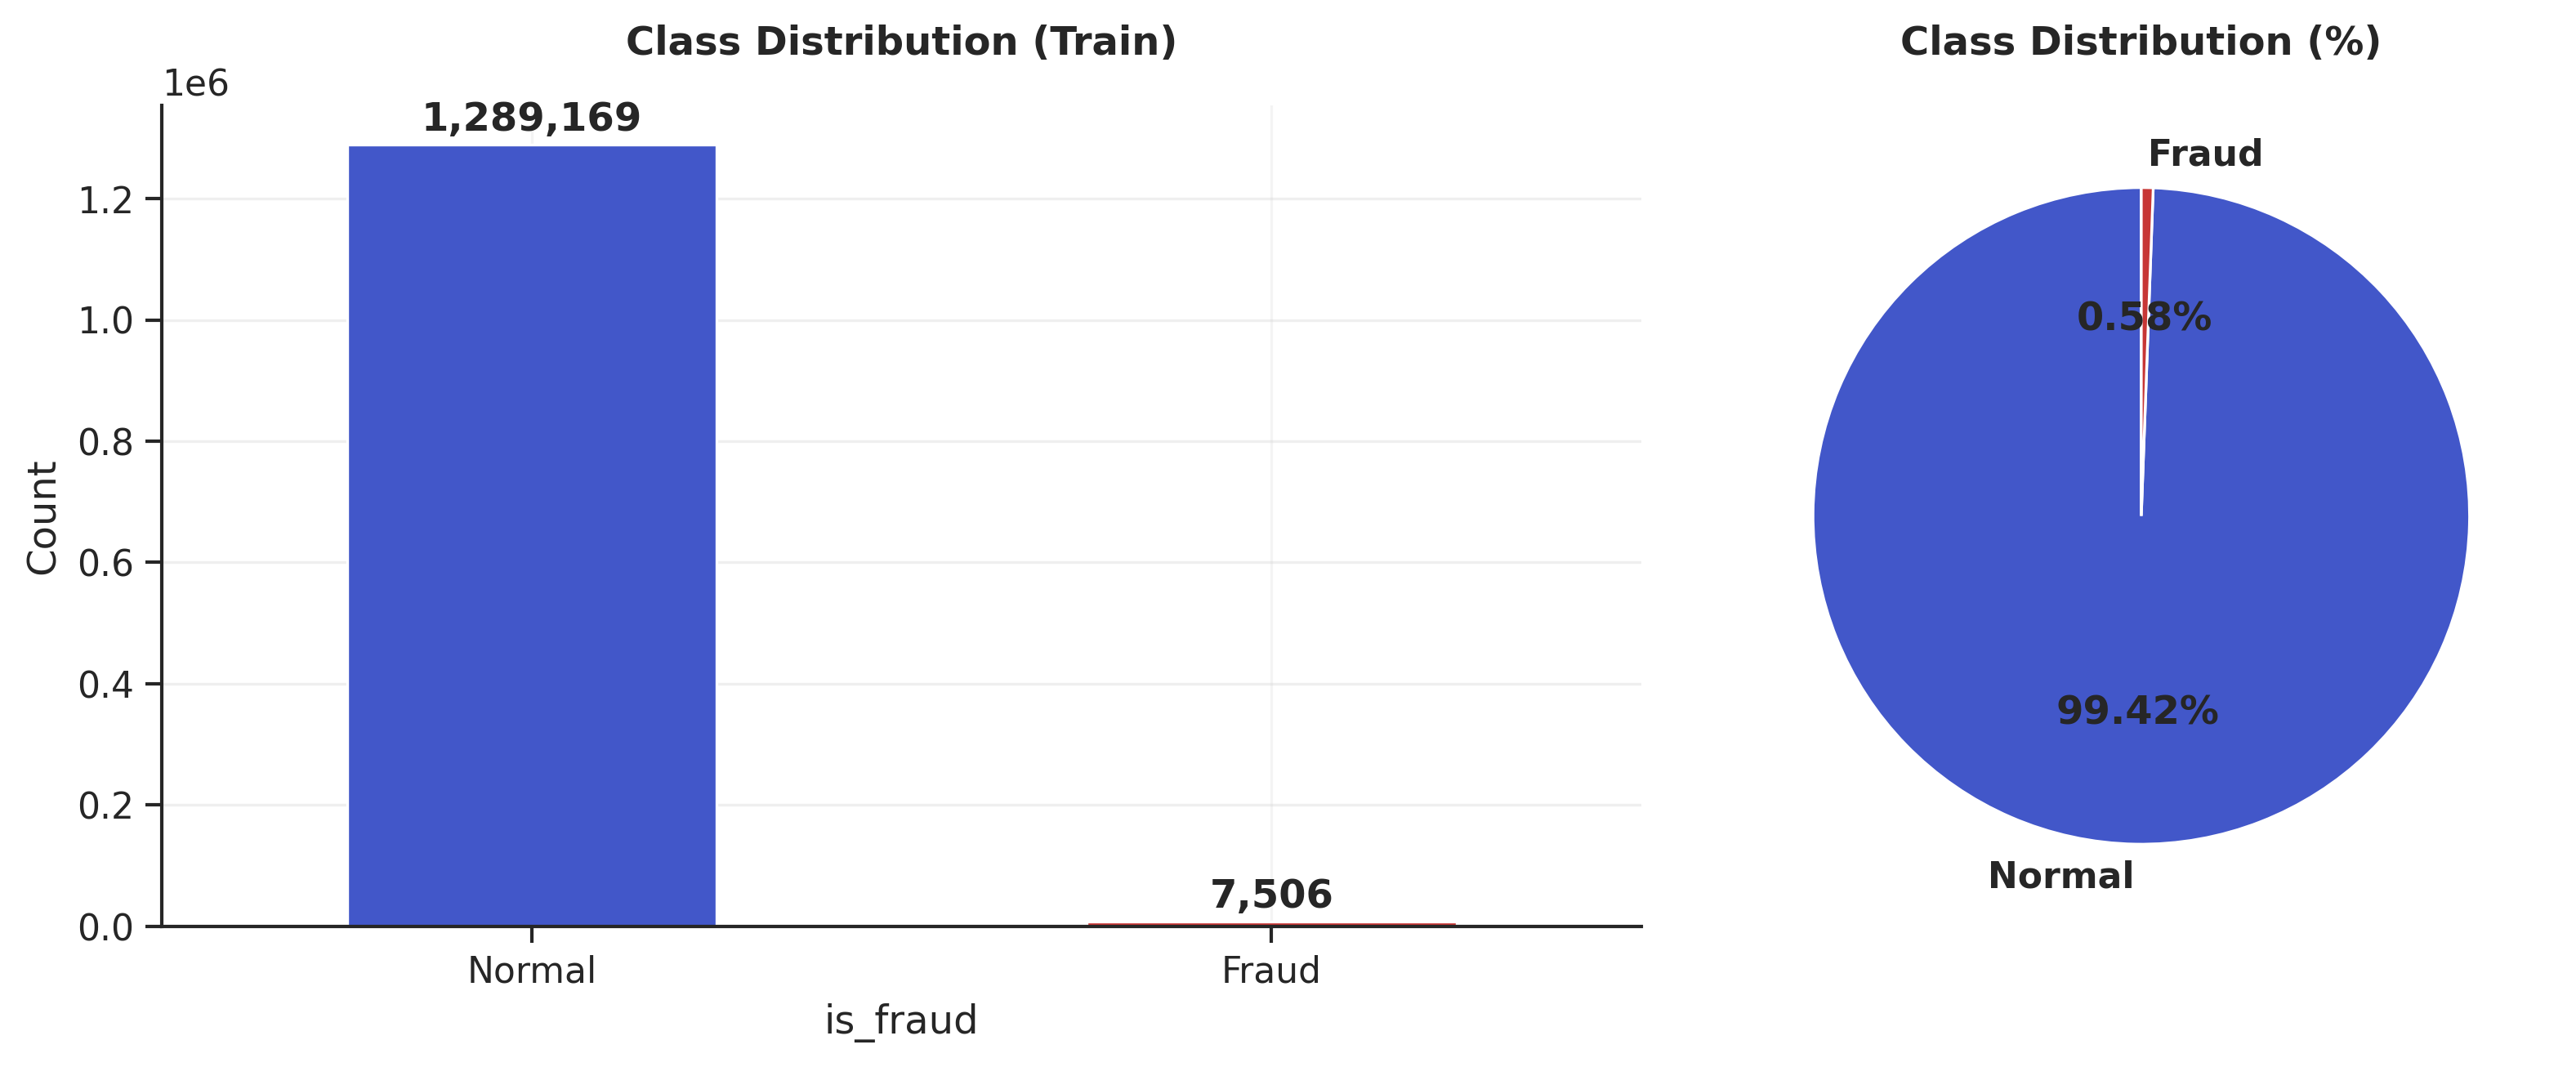


TRANSACTION AMOUNT ANALYSIS:
Normal transactions - Mean: $67.67, Median: $47.28
Fraud transactions - Mean: $531.32, Median: $396.50


/tmp/ipython-input-1996907304.py:88: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax4.boxplot(box_data, labels=['Normal', 'Fraud'], patch_artist=True,


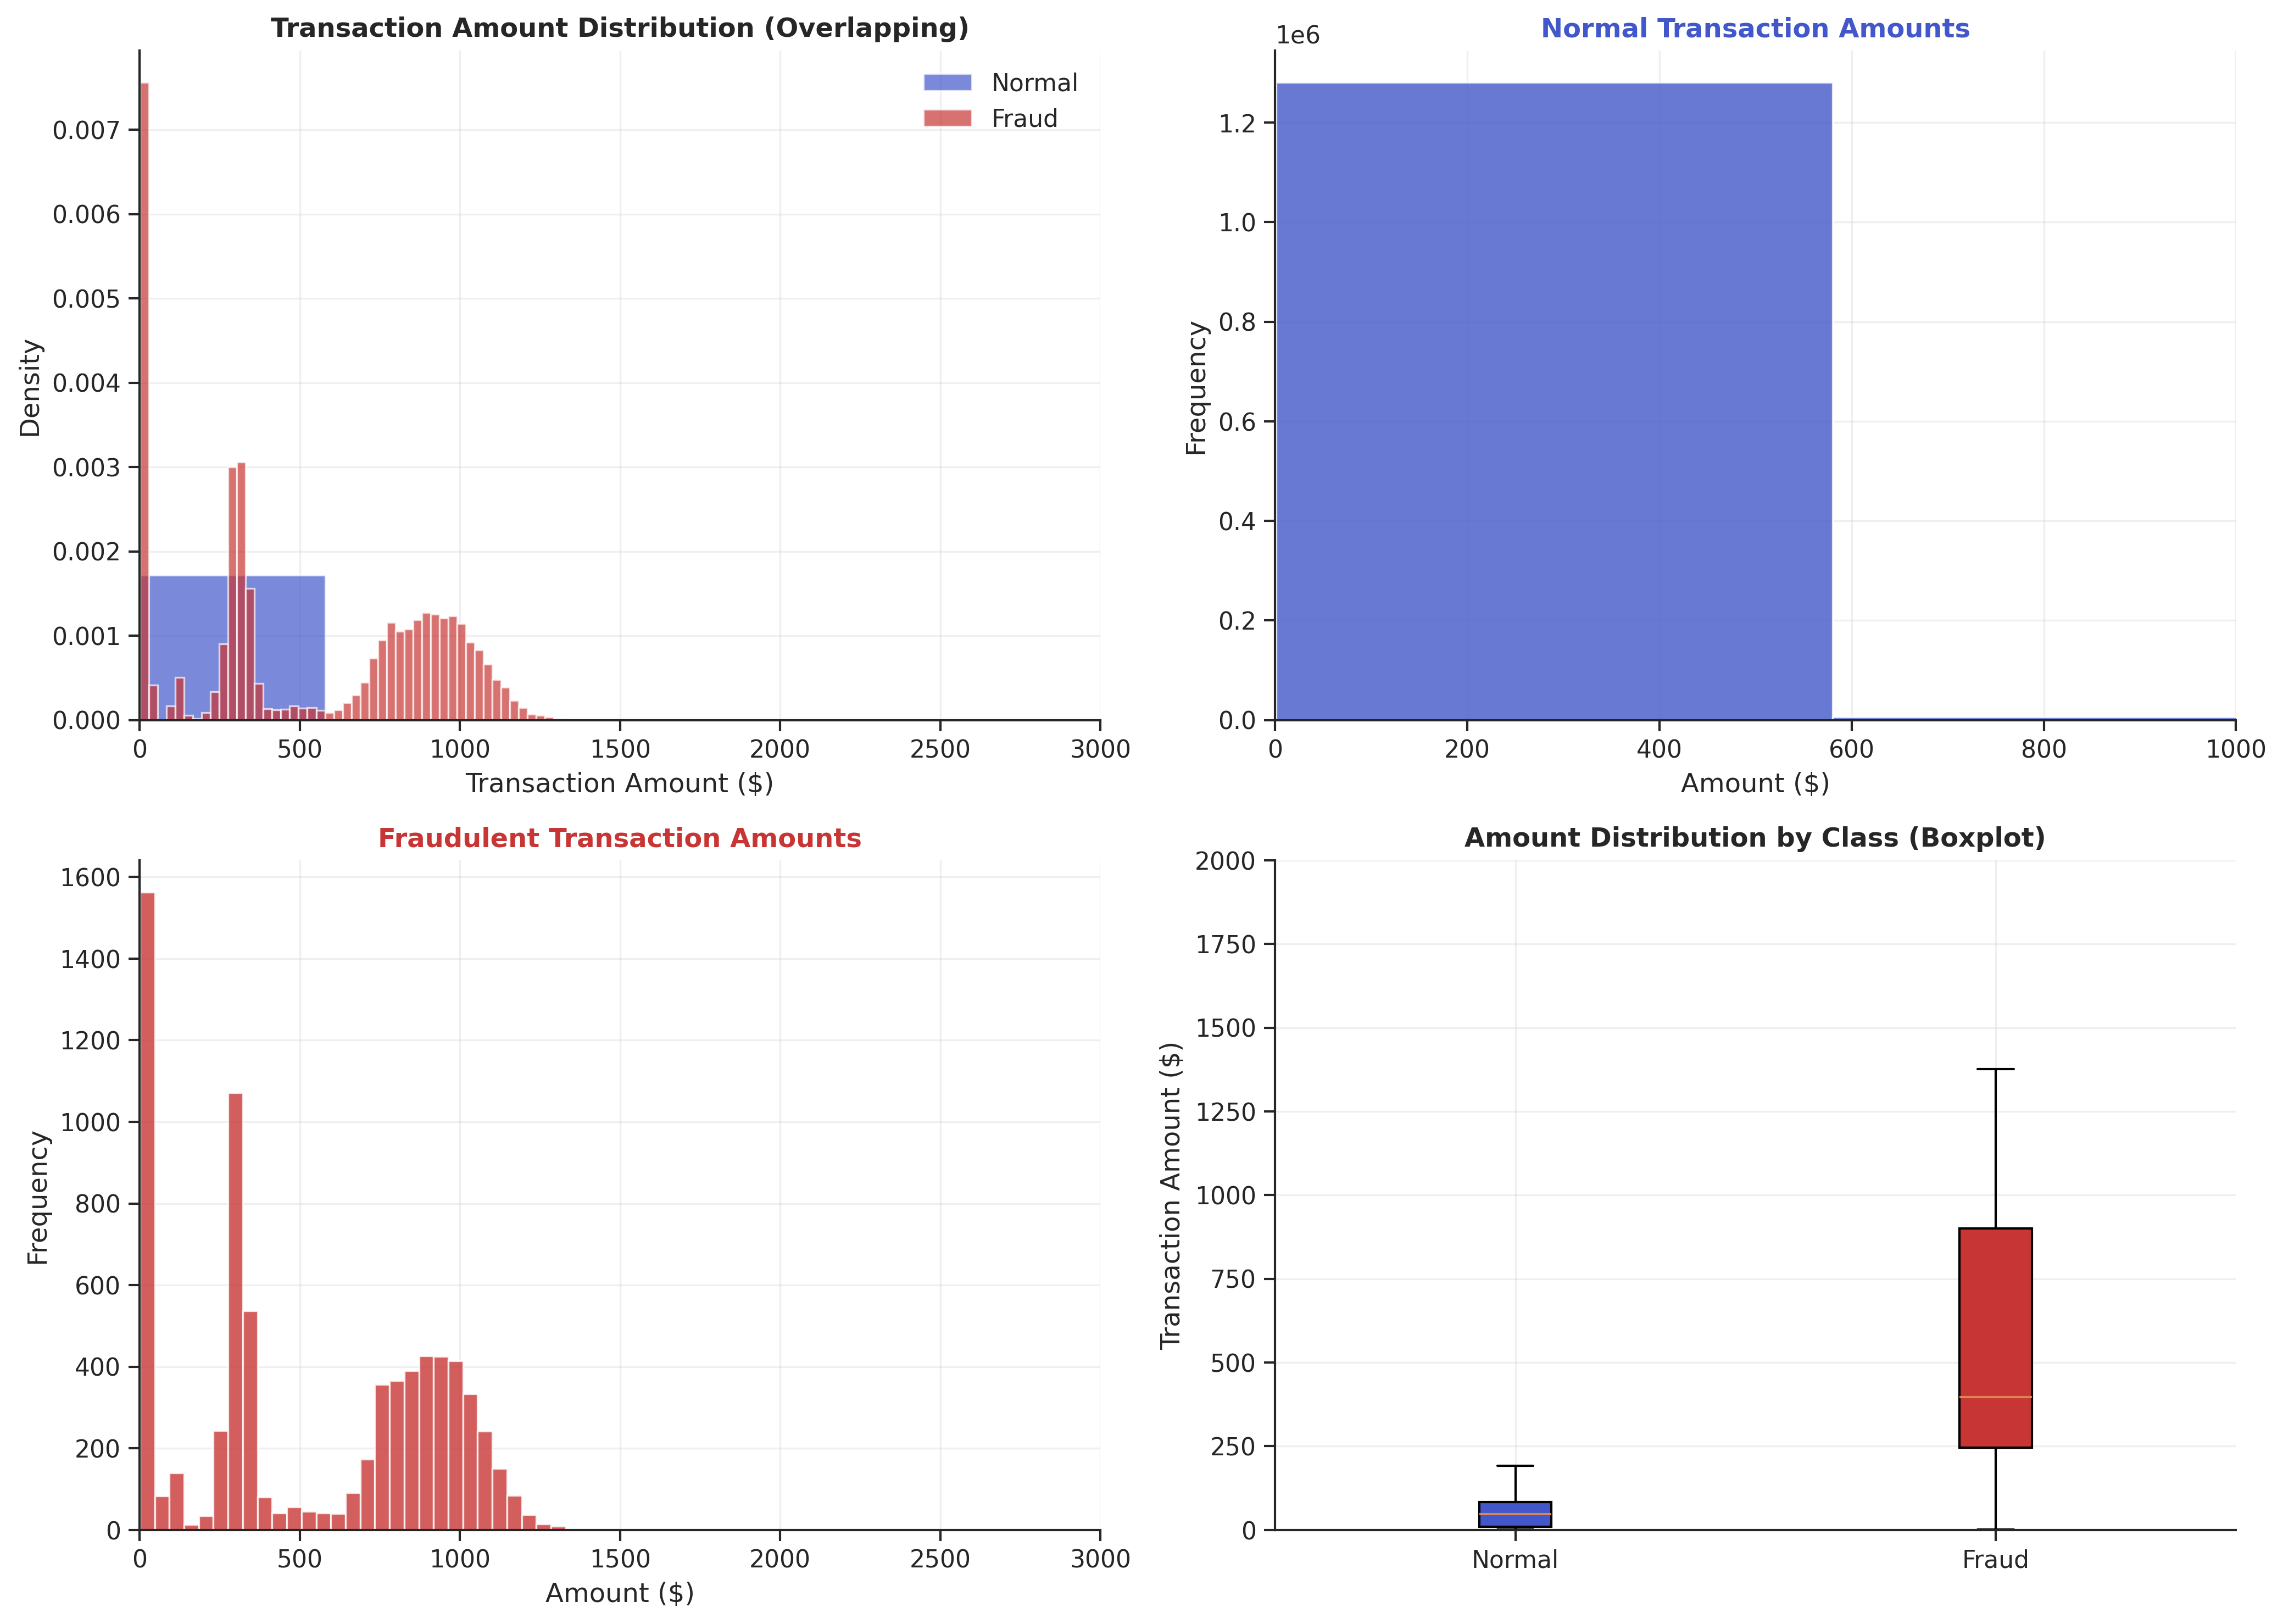


STATISTICAL INSIGHTS:
Amount difference (Fraud/Normal ratio): 7.85x
Fraud amount std dev: $390.56
Normal amount std dev: $154.01


In [4]:
print("\n" + "="*50)
print("PHASE 4: INITIAL EXPLORATORY DATA ANALYSIS")
print("="*50)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Use consistent color palette throughout
colors = sns.color_palette("deep")
fraud_color = "#c73635"    # Red for fraud
normal_color = "#4257c9"   # Green for normal

# Class distribution analysis
print("\nCLASS DISTRIBUTION (TRAIN):")
class_counts = train_data_clean['is_fraud'].value_counts()
print(class_counts)
print(f"Fraud rate: {train_data_clean['is_fraud'].mean():.4f} ({train_data_clean['is_fraud'].mean()*100:.2f}%)")

# Enhanced class distribution plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.5))

# Bar plot
class_counts.plot(kind='bar', color=[normal_color, fraud_color], ax=ax1)
ax1.set_title('Class Distribution (Train)', pad=15, weight="bold")
ax1.set_xticklabels(['Normal', 'Fraud'], rotation=0)
ax1.set_ylabel('Count')
ax1.grid(axis='y', alpha=0.3)

# Add count labels on bars
for i, v in enumerate(class_counts.values):
    ax1.text(i, v + 10000, f'{v:,}', ha='center', va='bottom', fontweight='bold')

# Pie chart
fraud_pct = train_data_clean['is_fraud'].value_counts(normalize=True) * 100
wedges, texts, autotexts = ax2.pie(fraud_pct.values,
                                  labels=['Normal', 'Fraud'],
                                  autopct='%1.2f%%',
                                  colors=[normal_color, fraud_color],
                                  startangle=90,
                                  textprops={'fontweight': 'bold'})
ax2.set_title('Class Distribution (%)', pad=15, weight="bold")

plt.tight_layout()
sns.despine()
savefig("fig_class_distribution_detailed.png")
plt.show()

# Transaction amount analysis
print(f"\nTRANSACTION AMOUNT ANALYSIS:")
fraud_amounts = train_data_clean[train_data_clean['is_fraud'] == 1]['amt']
normal_amounts = train_data_clean[train_data_clean['is_fraud'] == 0]['amt']

print(f"Normal transactions - Mean: ${normal_amounts.mean():.2f}, Median: ${normal_amounts.median():.2f}")
print(f"Fraud transactions - Mean: ${fraud_amounts.mean():.2f}, Median: ${fraud_amounts.median():.2f}")

# Enhanced amount distribution plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

# Histogram - overlapping
ax1.hist(normal_amounts, bins=50, alpha=0.7, label='Normal', color=normal_color, density=True)
ax1.hist(fraud_amounts, bins=50, alpha=0.7, label='Fraud', color=fraud_color, density=True)
ax1.set_xlabel('Transaction Amount ($)')
ax1.set_ylabel('Density')
ax1.set_title('Transaction Amount Distribution (Overlapping)', weight="bold")
ax1.legend()
ax1.set_xlim(0, 3000)
ax1.grid(alpha=0.3)

# Separate histograms
ax2.hist(normal_amounts, bins=50, color=normal_color, alpha=0.8)
ax2.set_title('Normal Transaction Amounts', weight="bold", color=normal_color)
ax2.set_xlabel('Amount ($)')
ax2.set_ylabel('Frequency')
ax2.set_xlim(0, 1000)
ax2.grid(alpha=0.3)

ax3.hist(fraud_amounts, bins=30, color=fraud_color, alpha=0.8)
ax3.set_title('Fraudulent Transaction Amounts', weight="bold", color=fraud_color)
ax3.set_xlabel('Amount ($)')
ax3.set_ylabel('Frequency')
ax3.set_xlim(0, 3000)
ax3.grid(alpha=0.3)

# Box plot comparison
box_data = [normal_amounts.values, fraud_amounts.values]
bp = ax4.boxplot(box_data, labels=['Normal', 'Fraud'], patch_artist=True,
                showfliers=False)  # Hide outliers for clarity
bp['boxes'][0].set_facecolor(normal_color)
bp['boxes'][1].set_facecolor(fraud_color)
ax4.set_ylabel('Transaction Amount ($)')
ax4.set_title('Amount Distribution by Class (Boxplot)', weight="bold")
ax4.set_ylim(0, 2000)
ax4.grid(alpha=0.3)

plt.tight_layout()
sns.despine()
savefig("fig_amount_analysis_comprehensive.png")
plt.show()

# Additional insights
print(f"\nSTATISTICAL INSIGHTS:")
print(f"Amount difference (Fraud/Normal ratio): {fraud_amounts.mean()/normal_amounts.mean():.2f}x")
print(f"Fraud amount std dev: ${fraud_amounts.std():.2f}")
print(f"Normal amount std dev: ${normal_amounts.std():.2f}")


In [5]:
print("\n" + "="*50)
print("PHASE 5: FEATURE ENGINEERING AND SELECTION")
print("="*50)

import pandas as pd  # Add this if missing

def engineer_and_select(df, name="DATA"):
    """Engineer features and select relevant columns for modeling"""
    df = df.copy()

    print(f"\n⚙️ ENGINEERING FEATURES FOR {name.upper()}...")

    # 1) Drop pure identifiers / PII-like low-utility columns
    drop_cols = ["Unnamed: 0", "cc_num", "first", "last", "street", "trans_num"]
    df.drop(columns=[c for c in drop_cols if c in df.columns], inplace=True, errors="ignore")

    # 2) Time features from trans_date_trans_time, then remove raw time fields
    if "trans_date_trans_time" in df.columns:
        print("Extracting datetime features...")
        dt = pd.to_datetime(df["trans_date_trans_time"], errors="coerce")
        df["trans_hour"] = dt.dt.hour
        df["trans_dow"] = dt.dt.dayofweek         # 0=Mon..6=Sun
        df["trans_day"] = dt.dt.day
        df["trans_month"] = dt.dt.month
        df.drop(columns=["trans_date_trans_time"], inplace=True, errors="ignore")
        print("Datetime features extracted")

    # 3) Age from dob, then drop dob (retain utility, remove PII)
    if "dob" in df.columns:
        print("Calculating age from date of birth...")
        dob = pd.to_datetime(df["dob"], errors="coerce")
        # use fixed reference to avoid time drift across runs
        ref = pd.Timestamp("2020-01-01")
        df["age"] = ((ref - dob).dt.days // 365).astype("float32")
        df.drop(columns=["dob"], inplace=True, errors="ignore")
        print("Age feature created")

    # 4) Remove redundant time index if present
    df.drop(columns=[c for c in ["unix_time"] if c in df.columns], inplace=True, errors="ignore")

    # 5) Choose one geographic representation: keep state/zip and drop raw coordinates
    for c in ["lat", "long", "merch_lat", "merch_long"]:
        if c in df.columns:
            df.drop(columns=c, inplace=True)

    # 6) If both trans_dow and an is_weekend flag exist, keep only one
    if "is_weekend" in df.columns:
        df.drop(columns=["is_weekend"], inplace=True)

    return df

# Apply feature engineering (make sure train_data_clean and test_data_clean exist)
try:
    train_engineered = engineer_and_select(train_data_clean, "TRAIN")
    test_engineered = engineer_and_select(test_data_clean, "TEST")

    # Updated feature lists after pruning
    high_card_cat = [c for c in ["merchant", "city"] if c in train_engineered.columns]
    low_card_cat = [c for c in ["category", "gender", "state"] if c in train_engineered.columns]
    numeric_feats = [c for c in ["amt", "zip", "city_pop", "age", "trans_hour", "trans_dow", "trans_day", "trans_month"] if c in train_engineered.columns]
    target_col = "is_fraud"

    print(f"\n📊 FEATURE SUMMARY:")
    print(f"High-cardinality categorical: {len(high_card_cat)} features")
    print(f"Low-cardinality categorical: {len(low_card_cat)} features")
    print(f"Numeric features: {len(numeric_feats)} features")
    print(f"Total features: {len(high_card_cat) + len(low_card_cat) + len(numeric_feats)}")

except NameError as e:
    print(f"ERROR: {e}")
    print("Make sure you've run the previous phases to create train_data_clean and test_data_clean")



PHASE 5: FEATURE ENGINEERING AND SELECTION

⚙️ ENGINEERING FEATURES FOR TRAIN...
Extracting datetime features...
Datetime features extracted
Calculating age from date of birth...
Age feature created

⚙️ ENGINEERING FEATURES FOR TEST...
Extracting datetime features...
Datetime features extracted
Calculating age from date of birth...
Age feature created

📊 FEATURE SUMMARY:
High-cardinality categorical: 2 features
Low-cardinality categorical: 3 features
Numeric features: 8 features
Total features: 13



PHASE 6: INITIAL CORRELATION ANALYSIS


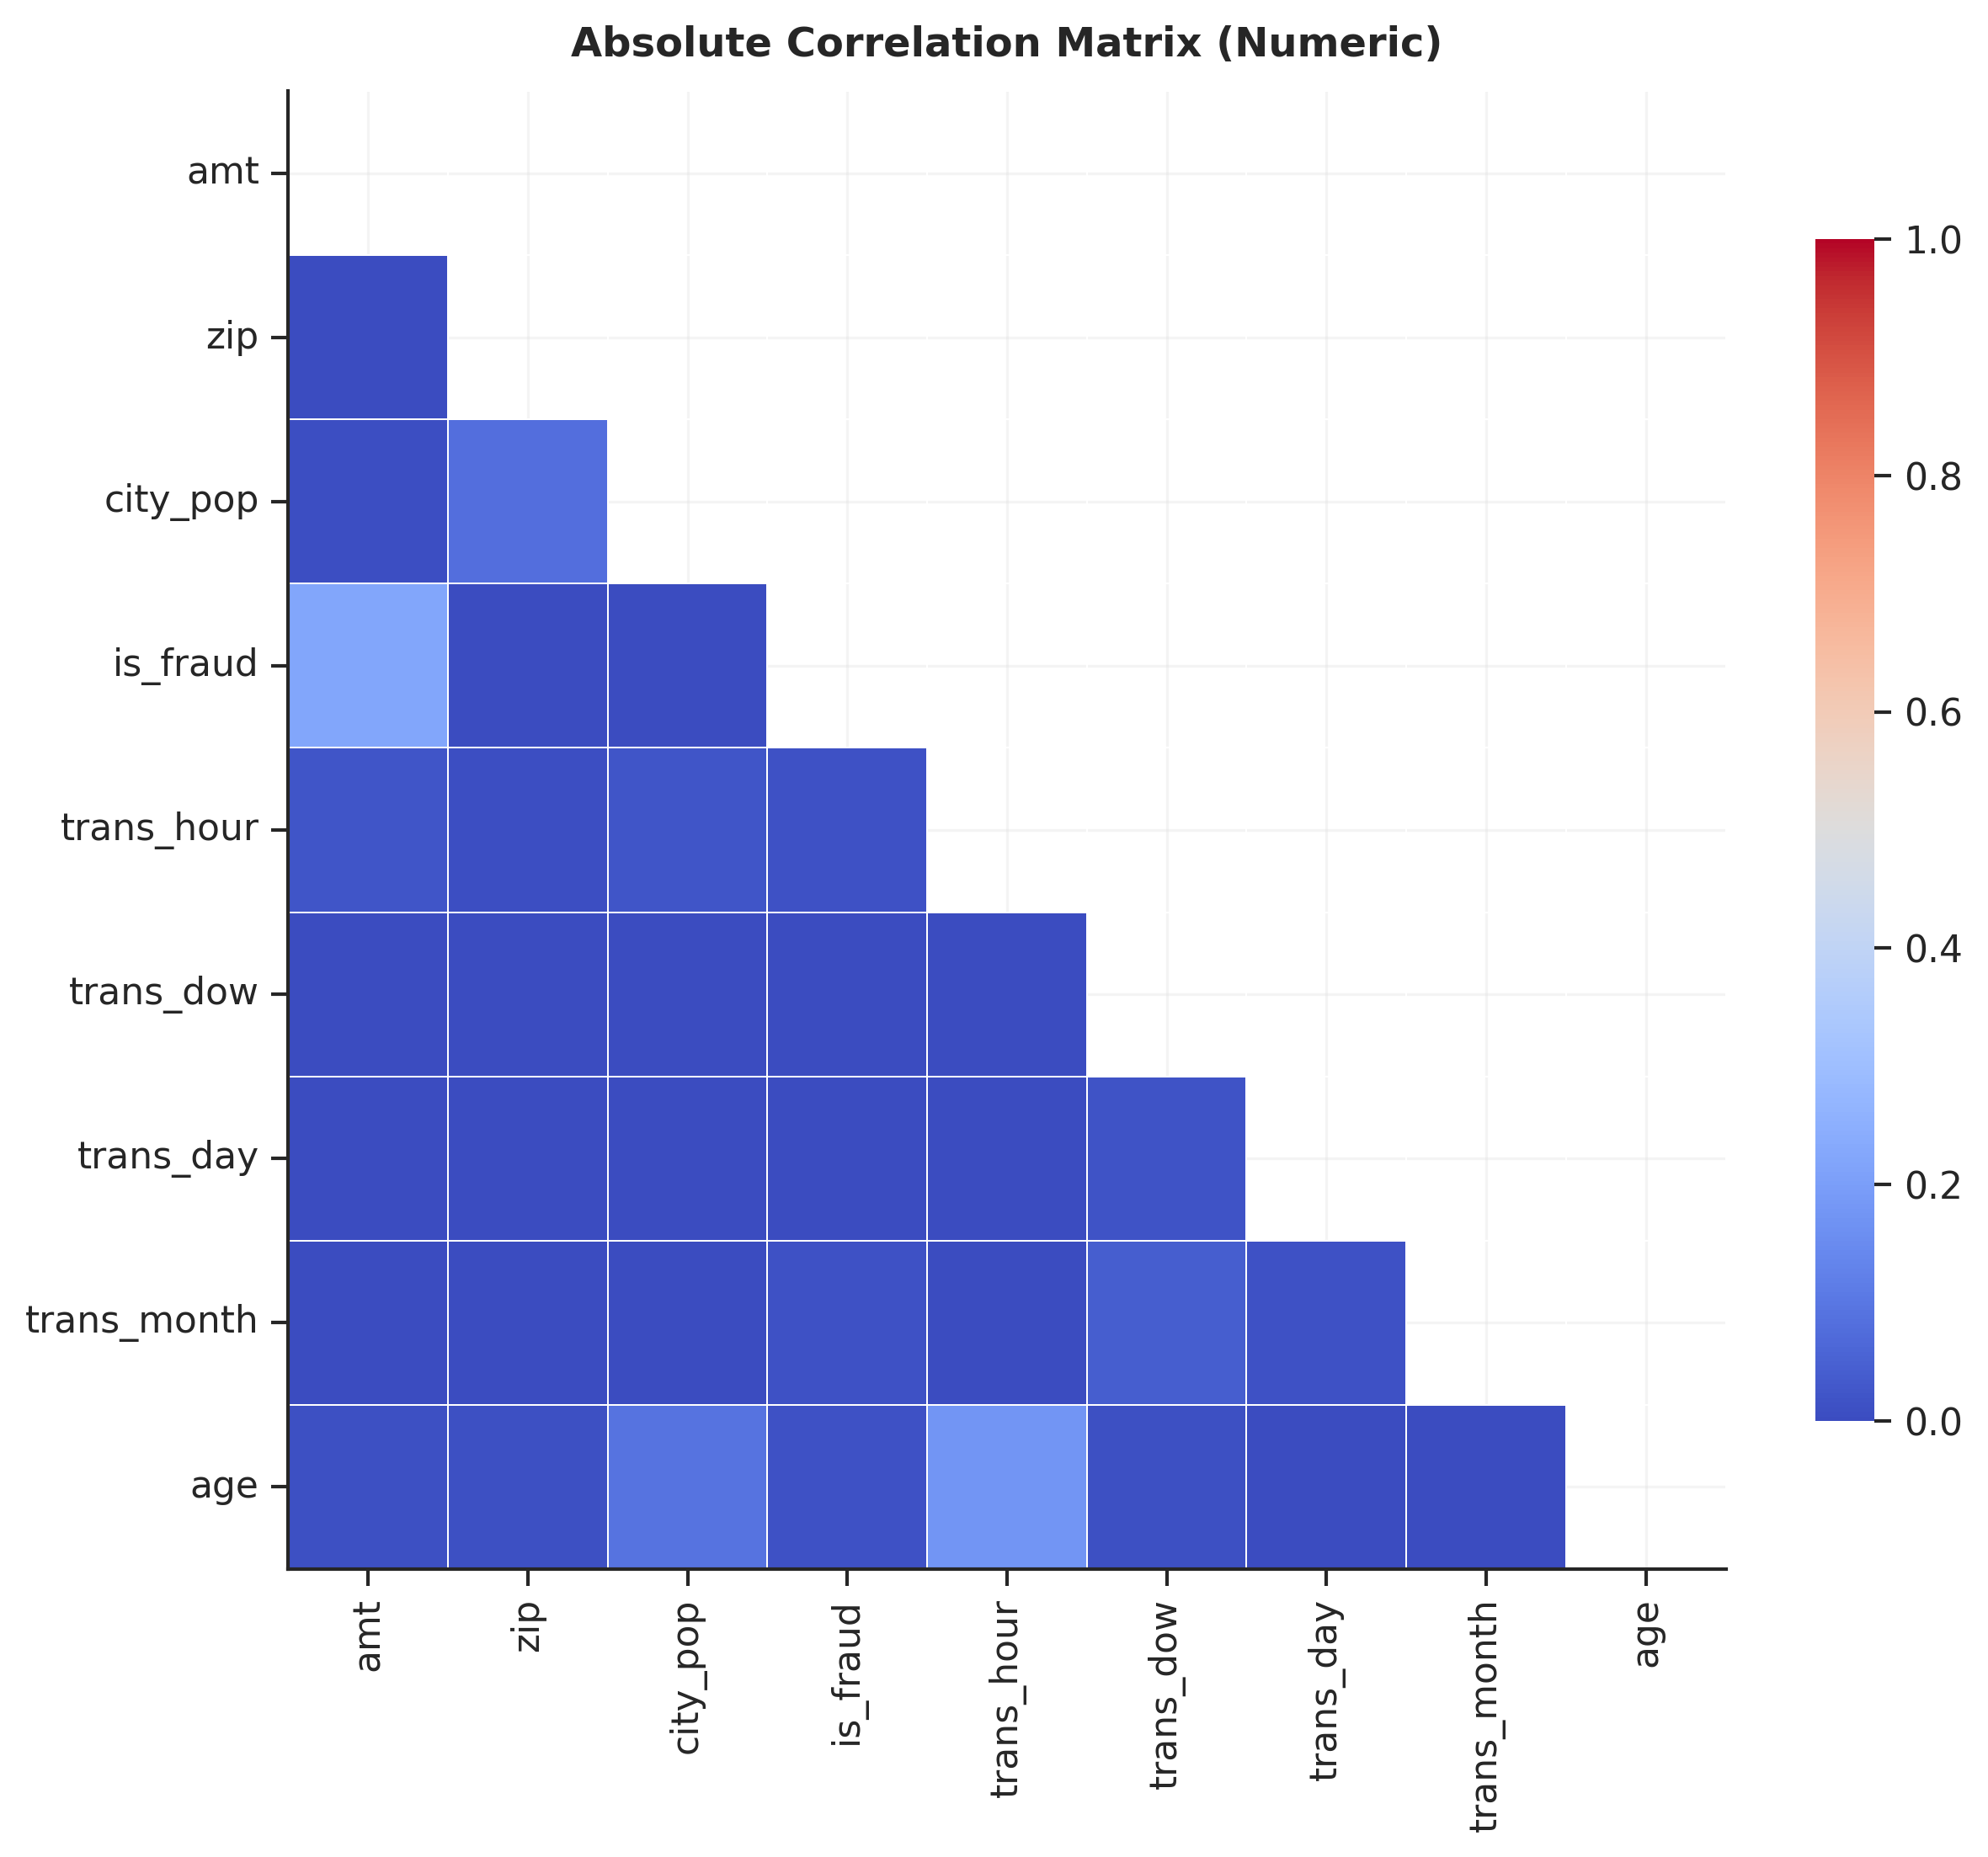

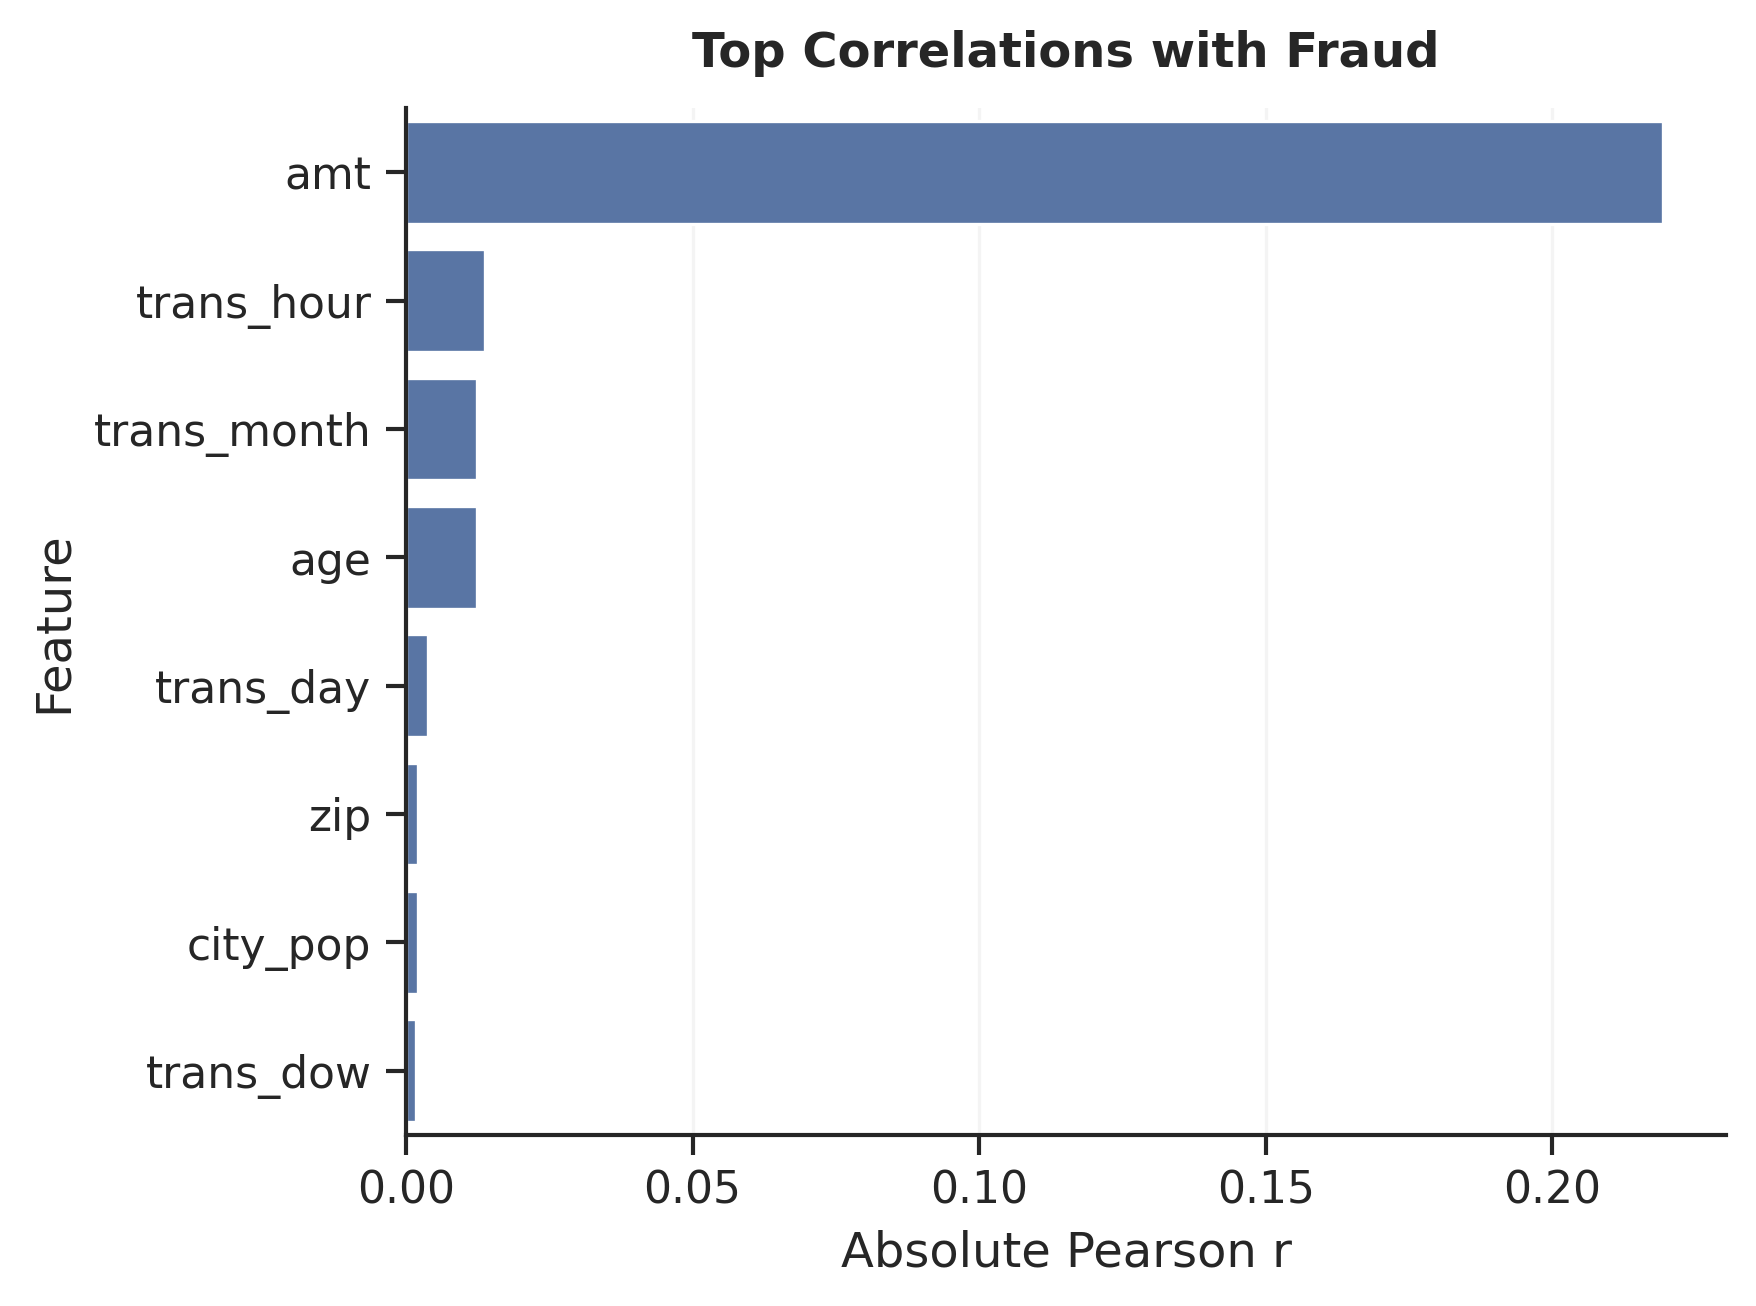

In [6]:
print("\n" + "="*50)
print("PHASE 6: INITIAL CORRELATION ANALYSIS")
print("="*50)

import numpy as np

# Get numeric features only
num_block = train_engineered[[c for c in train_engineered.columns if train_engineered[c].dtype != "O"]]
corr = num_block.corr()           # Pearson
abs_corr = corr.abs()

# Heatmap (lower triangle, absolute values)
mask = np.triu(np.ones_like(abs_corr, dtype=bool))
fig, ax = plt.subplots(figsize=(8.5, 7.5))
sns.heatmap(abs_corr, mask=mask, cmap="coolwarm", vmin=0, vmax=1, annot=False, linewidths=0.4, cbar_kws={"shrink": 0.8})
finalize_axes(ax, title="Absolute Correlation Matrix (Numeric)")
savefig("fig_corr_matrix.png")
plt.show()

# Top correlations with target (excluding self)
if target_col in abs_corr.columns:
    top = abs_corr[target_col].drop(target_col).sort_values(ascending=False).head(12)
    fig, ax = plt.subplots(figsize=(6.0, 4.5))
    # FIX: Use a single color instead of entire palette
    sns.barplot(x=top.values, y=top.index, color=sns.color_palette()[0], ax=ax)
    finalize_axes(ax, xlabel="Absolute Pearson r", ylabel="Feature", title="Top Correlations with Fraud")
    savefig("fig_top_corr_with_target.png")
    plt.show()


In [7]:
# Install imbalanced-learn first (run this in Colab)
!pip install -q imbalanced-learn

print("\n" + "="*50)
print("PHASE 7: ENCODING AND SCALING")
print("="*50)

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, TargetEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE

# Column groups (ensure they exist)
high_card_cat = [c for c in high_card_cat if c in train_engineered.columns]
low_card_cat = [c for c in low_card_cat if c in train_engineered.columns]
numeric_feats = [c for c in numeric_feats if c in train_engineered.columns]

# Split features/target
X_train_df = train_engineered[high_card_cat + low_card_cat + numeric_feats]
y_train = train_engineered[target_col].astype(int).values
X_test_df = test_engineered[high_card_cat + low_card_cat + numeric_feats]
y_test = test_engineered[target_col].astype(int).values

# Build preprocessing: TargetEncoder for high-card, OneHot for low-card, MinMax for numeric
preprocess = ColumnTransformer(
    transformers=[
        ("tgt", TargetEncoder(cv=5, random_state=42), high_card_cat),
        ("ohe", OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=True), low_card_cat),  # FIXED: sparse_output instead of sparse
        ("num", MinMaxScaler(), numeric_feats),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

# Fit on train, transform train/test (leakage-safe)
X_train_processed = preprocess.fit_transform(X_train_df, y_train)
X_test_processed = preprocess.transform(X_test_df)

print(f"Train processed shape: {X_train_processed.shape}")
print(f"Test processed shape: {X_test_processed.shape}")

# Address class imbalance: SMOTE on train only (post-transform)
sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train_processed, y_train)

print(f"Balanced train shape: {X_train_bal.shape} (fraud ratio ~50/50 after SMOTE)")
print(f"Original fraud rate: {y_train.mean():.4f}")
print(f"Balanced fraud rate: {y_train_bal.mean():.4f}")



PHASE 7: ENCODING AND SCALING
Train processed shape: (1296675, 74)
Test processed shape: (555719, 74)
Balanced train shape: (2578338, 74) (fraud ratio ~50/50 after SMOTE)
Original fraud rate: 0.0058
Balanced fraud rate: 0.5000



PHASE 8: POST-ENCODING VALIDATION

FINAL DATASET STATISTICS:
Training samples: 1,296,675
Test samples: 555,719
Total features after encoding: 74
Train fraud rate: 0.0058
Test fraud rate: 0.0039

MEMORY USAGE:
Processed train data: 179.79 MB
Processed test data: 77.61 MB
Training data sparsity: 0.8408

DATA QUALITY CHECK:
Training data contains NaN: False
Test data contains NaN: False


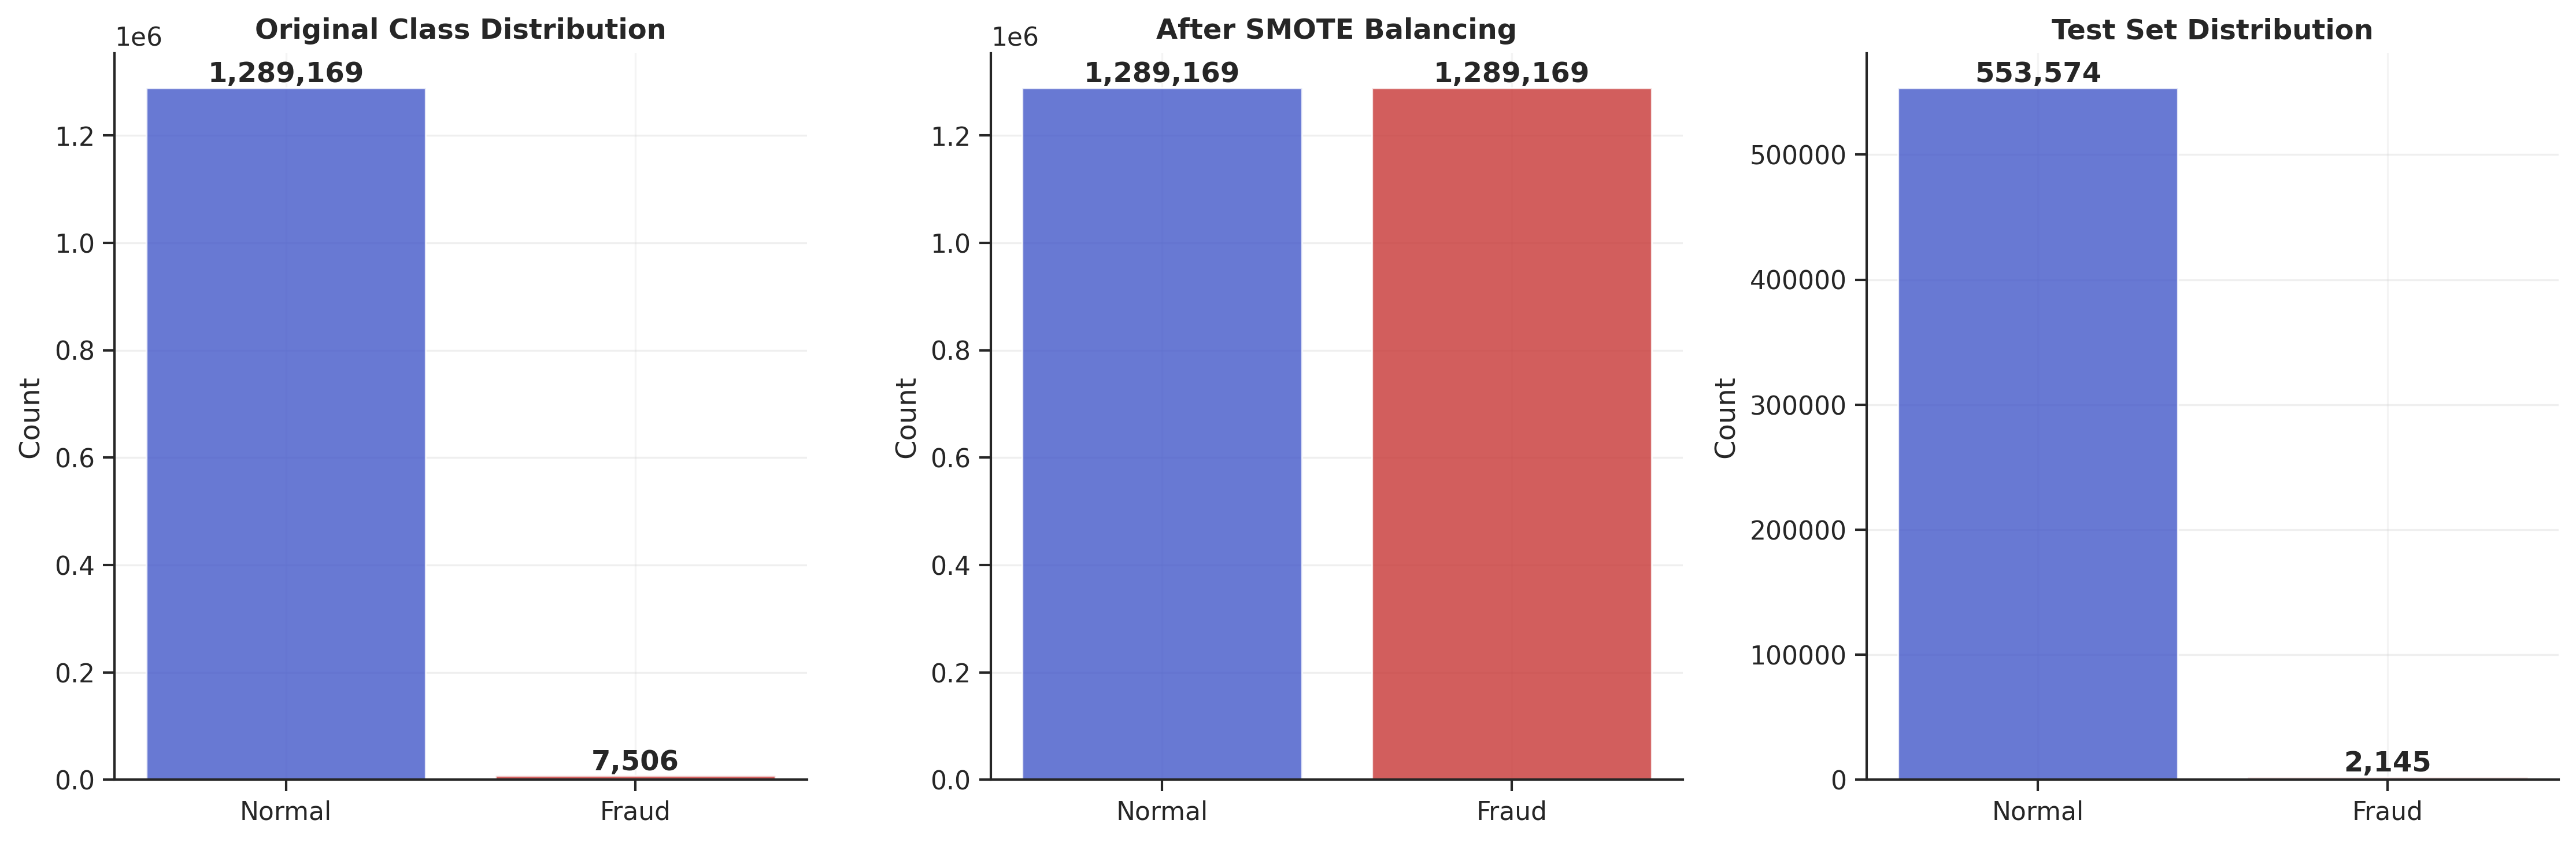


FEATURE ENGINEERING SUMMARY:
High-cardinality categorical features: 2
Low-cardinality categorical features: 3
Numeric features: 8
Total input features: 13
Features after encoding: 74

DATA PREPROCESSING COMPLETE!
Ready for ensemble model training with uncertainty quantification.


In [8]:
print("\n" + "="*50)
print("PHASE 8: POST-ENCODING VALIDATION")
print("="*50)

import scipy.sparse as sp

# Memory usage calculation for sparse matrices
def mem_mb(arr):
    if sp.issparse(arr):
        return (arr.data.nbytes + arr.indptr.nbytes + arr.indices.nbytes) / 1024**2
    return arr.nbytes / 1024**2

# Final dataset statistics
print(f"\nFINAL DATASET STATISTICS:")
print(f"Training samples: {X_train_processed.shape[0]:,}")
print(f"Test samples: {X_test_processed.shape[0]:,}")
print(f"Total features after encoding: {X_train_processed.shape[1]:,}")
print(f"Train fraud rate: {y_train.mean():.4f}")
print(f"Test fraud rate: {y_test.mean():.4f}")

# Memory and sparsity analysis
train_memory = mem_mb(X_train_processed)
test_memory = mem_mb(X_test_processed)
print(f"\nMEMORY USAGE:")
print(f"Processed train data: {train_memory:.2f} MB")
print(f"Processed test data: {test_memory:.2f} MB")

if sp.issparse(X_train_processed):
    sparsity = 1 - X_train_processed.nnz / np.prod(X_train_processed.shape)
    print(f"Training data sparsity: {sparsity:.4f}")

# Data quality check
print(f"\nDATA QUALITY CHECK:")
print(f"Training data contains NaN: {np.isnan(X_train_processed.data).any() if sp.issparse(X_train_processed) else np.isnan(X_train_processed).any()}")
print(f"Test data contains NaN: {np.isnan(X_test_processed.data).any() if sp.issparse(X_test_processed) else np.isnan(X_test_processed).any()}")

# Enhanced class distribution visualization
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Original distribution
counts_orig = pd.Series(y_train).value_counts().sort_index()
bars1 = ax1.bar(['Normal', 'Fraud'], counts_orig.values,
               color=[normal_color, fraud_color], alpha=0.8)
ax1.set_title('Original Class Distribution', weight="bold")
ax1.set_ylabel('Count')
ax1.grid(axis='y', alpha=0.3)
for i, v in enumerate(counts_orig.values):
    ax1.text(i, v, f'{v:,}', ha='center', va='bottom', fontweight='bold')

# Balanced distribution (after SMOTE)
counts_bal = pd.Series(y_train_bal).value_counts().sort_index()
bars2 = ax2.bar(['Normal', 'Fraud'], counts_bal.values,
               color=[normal_color, fraud_color], alpha=0.8)
ax2.set_title('After SMOTE Balancing', weight="bold")
ax2.set_ylabel('Count')
ax2.grid(axis='y', alpha=0.3)
for i, v in enumerate(counts_bal.values):
    ax2.text(i, v, f'{v:,}', ha='center', va='bottom', fontweight='bold')

# Test distribution
counts_test = pd.Series(y_test).value_counts().sort_index()
bars3 = ax3.bar(['Normal', 'Fraud'], counts_test.values,
               color=[normal_color, fraud_color], alpha=0.8)
ax3.set_title('Test Set Distribution', weight="bold")
ax3.set_ylabel('Count')
ax3.grid(axis='y', alpha=0.3)
for i, v in enumerate(counts_test.values):
    ax3.text(i, v, f'{v:,}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
sns.despine()
savefig("fig_final_class_distributions.png")
plt.show()

# Feature engineering summary
print(f"\nFEATURE ENGINEERING SUMMARY:")
print(f"High-cardinality categorical features: {len(high_card_cat)}")
print(f"Low-cardinality categorical features: {len(low_card_cat)}")
print(f"Numeric features: {len(numeric_feats)}")
print(f"Total input features: {len(high_card_cat) + len(low_card_cat) + len(numeric_feats)}")
print(f"Features after encoding: {X_train_processed.shape[1]}")

print(f"\nDATA PREPROCESSING COMPLETE!")
print(f"Ready for ensemble model training with uncertainty quantification.")


In [9]:
print("\n" + "="*50)
print("EXPORTING DATASETS FOR FUTURE TRAINING")
print("="*50)

import numpy as np
import scipy.sparse as sp

def save_processed_datasets():
    """
    Save both CSV files and numpy arrays for future model training
    """
    # Columns to drop (not needed for training)
    drop_cols = [
        'Unnamed: 0', 'cc_num', 'first', 'last', 'street', 'trans_num',
        'unix_time', 'lat', 'long', 'merch_lat', 'merch_long', 'dob',
        'trans_date_trans_time', 'is_weekend'
    ]

    # Clean the datasets by dropping unnecessary columns
    train_final = train_engineered.drop(columns=[col for col in drop_cols if col in train_engineered.columns], errors='ignore')
    test_final = test_engineered.drop(columns=[col for col in drop_cols if col in test_engineered.columns], errors='ignore')

    print(f"Original train features: {len(train_engineered.columns)}")
    print(f"Final train features: {len(train_final.columns)}")
    print(f"Dropped {len(train_engineered.columns) - len(train_final.columns)} unnecessary columns")

    # 1. SAVE AS CSV FILES (for easy loading in future sessions)
    print("\nSaving CSV files...")
    train_final.to_csv('train_processed_clean.csv', index=False)
    test_final.to_csv('test_processed_clean.csv', index=False)
    print("Saved: train_processed_clean.csv, test_processed_clean.csv")

    # 2. SAVE NUMPY ARRAYS (for direct model training)
    print("\nSaving numpy arrays...")

    # Labels
    np.save('y_train_final.npy', y_train)
    np.save('y_test_final.npy', y_test)
    np.save('y_train_balanced_final.npy', y_train_bal)

    # Features (sparse or dense)
    if sp.issparse(X_train_processed):
        sp.save_npz('X_train_processed_final.npz', X_train_processed)
        sp.save_npz('X_test_processed_final.npz', X_test_processed)
        sp.save_npz('X_train_balanced_final.npz', X_train_bal)
        print("Saved sparse matrices to .npz files")
    else:
        np.save('X_train_processed_final.npy', X_train_processed)
        np.save('X_test_processed_final.npy', X_test_processed)
        np.save('X_train_balanced_final.npy', X_train_bal)
        print("Saved dense matrices to .npy files")

    # 3. SAVE PREPROCESSING PIPELINE (for consistency)
    import joblib
    joblib.dump(preprocess, 'preprocessing_pipeline.pkl')
    print("Saved preprocessing pipeline")

    print(f"\nALL FILES READY FOR FUTURE TRAINING:")
    print("CSV Files (easy loading):")
    print("   - train_processed_clean.csv")
    print("   - test_processed_clean.csv")
    print("Numpy Arrays (direct training):")
    print("   - X_train_processed_final.npz/npy")
    print("   - X_test_processed_final.npz/npy")
    print("   - X_train_balanced_final.npz/npy (SMOTE balanced)")
    print("   - y_train_final.npy, y_test_final.npy, y_train_balanced_final.npy")
    print("🔧 Pipeline:")
    print("   - preprocessing_pipeline.pkl")

    return train_final, test_final

# Execute the saving function
train_clean, test_clean = save_processed_datasets()

# Quick loading example for future use
print(f"\nQUICK LOADING EXAMPLES:")
print("# Load CSV files:")
print("train_df = pd.read_csv('train_processed_clean.csv')")
print("test_df = pd.read_csv('test_processed_clean.csv')")
print()
print("# Load numpy arrays:")
print("X_train = sp.load_npz('X_train_processed_final.npz')  # or np.load for .npy")
print("y_train = np.load('y_train_final.npy')")
print("X_train_balanced = sp.load_npz('X_train_balanced_final.npz')")
print("y_train_balanced = np.load('y_train_balanced_final.npy')")
print()
print("# Load preprocessing pipeline:")
print("pipeline = joblib.load('preprocessing_pipeline.pkl')")



EXPORTING DATASETS FOR FUTURE TRAINING
Original train features: 15
Final train features: 15
Dropped 0 unnecessary columns

Saving CSV files...
Saved: train_processed_clean.csv, test_processed_clean.csv

Saving numpy arrays...
Saved sparse matrices to .npz files
Saved preprocessing pipeline

ALL FILES READY FOR FUTURE TRAINING:
CSV Files (easy loading):
   - train_processed_clean.csv
   - test_processed_clean.csv
Numpy Arrays (direct training):
   - X_train_processed_final.npz/npy
   - X_test_processed_final.npz/npy
   - X_train_balanced_final.npz/npy (SMOTE balanced)
   - y_train_final.npy, y_test_final.npy, y_train_balanced_final.npy
🔧 Pipeline:
   - preprocessing_pipeline.pkl

QUICK LOADING EXAMPLES:
# Load CSV files:
train_df = pd.read_csv('train_processed_clean.csv')
test_df = pd.read_csv('test_processed_clean.csv')

# Load numpy arrays:
X_train = sp.load_npz('X_train_processed_final.npz')  # or np.load for .npy
y_train = np.load('y_train_final.npy')
X_train_balanced = sp.load_npz

#**Model Training**